In [1]:
from icevision.all import *

In [2]:
%matplotlib inline  

In [3]:
import icedata

In [5]:
url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip"
dest_dir = "fridge"
data_dir = icedata.load_data(url, dest_dir)

In [6]:
parser = parsers.VOCBBoxParser(annotations_dir=data_dir / "odFridgeObjects/annotations", images_dir=data_dir / "odFridgeObjects/images")


In [7]:
train_records, valid_records = parser.parse()
parser.class_map

  0%|          | 0/128 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/128 [00:00<?, ?it/s]

<ClassMap: {'background': 0, 'carton': 1, 'milk_bottle': 2, 'can': 3, 'water_bottle': 4}>

In [8]:
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [9]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)


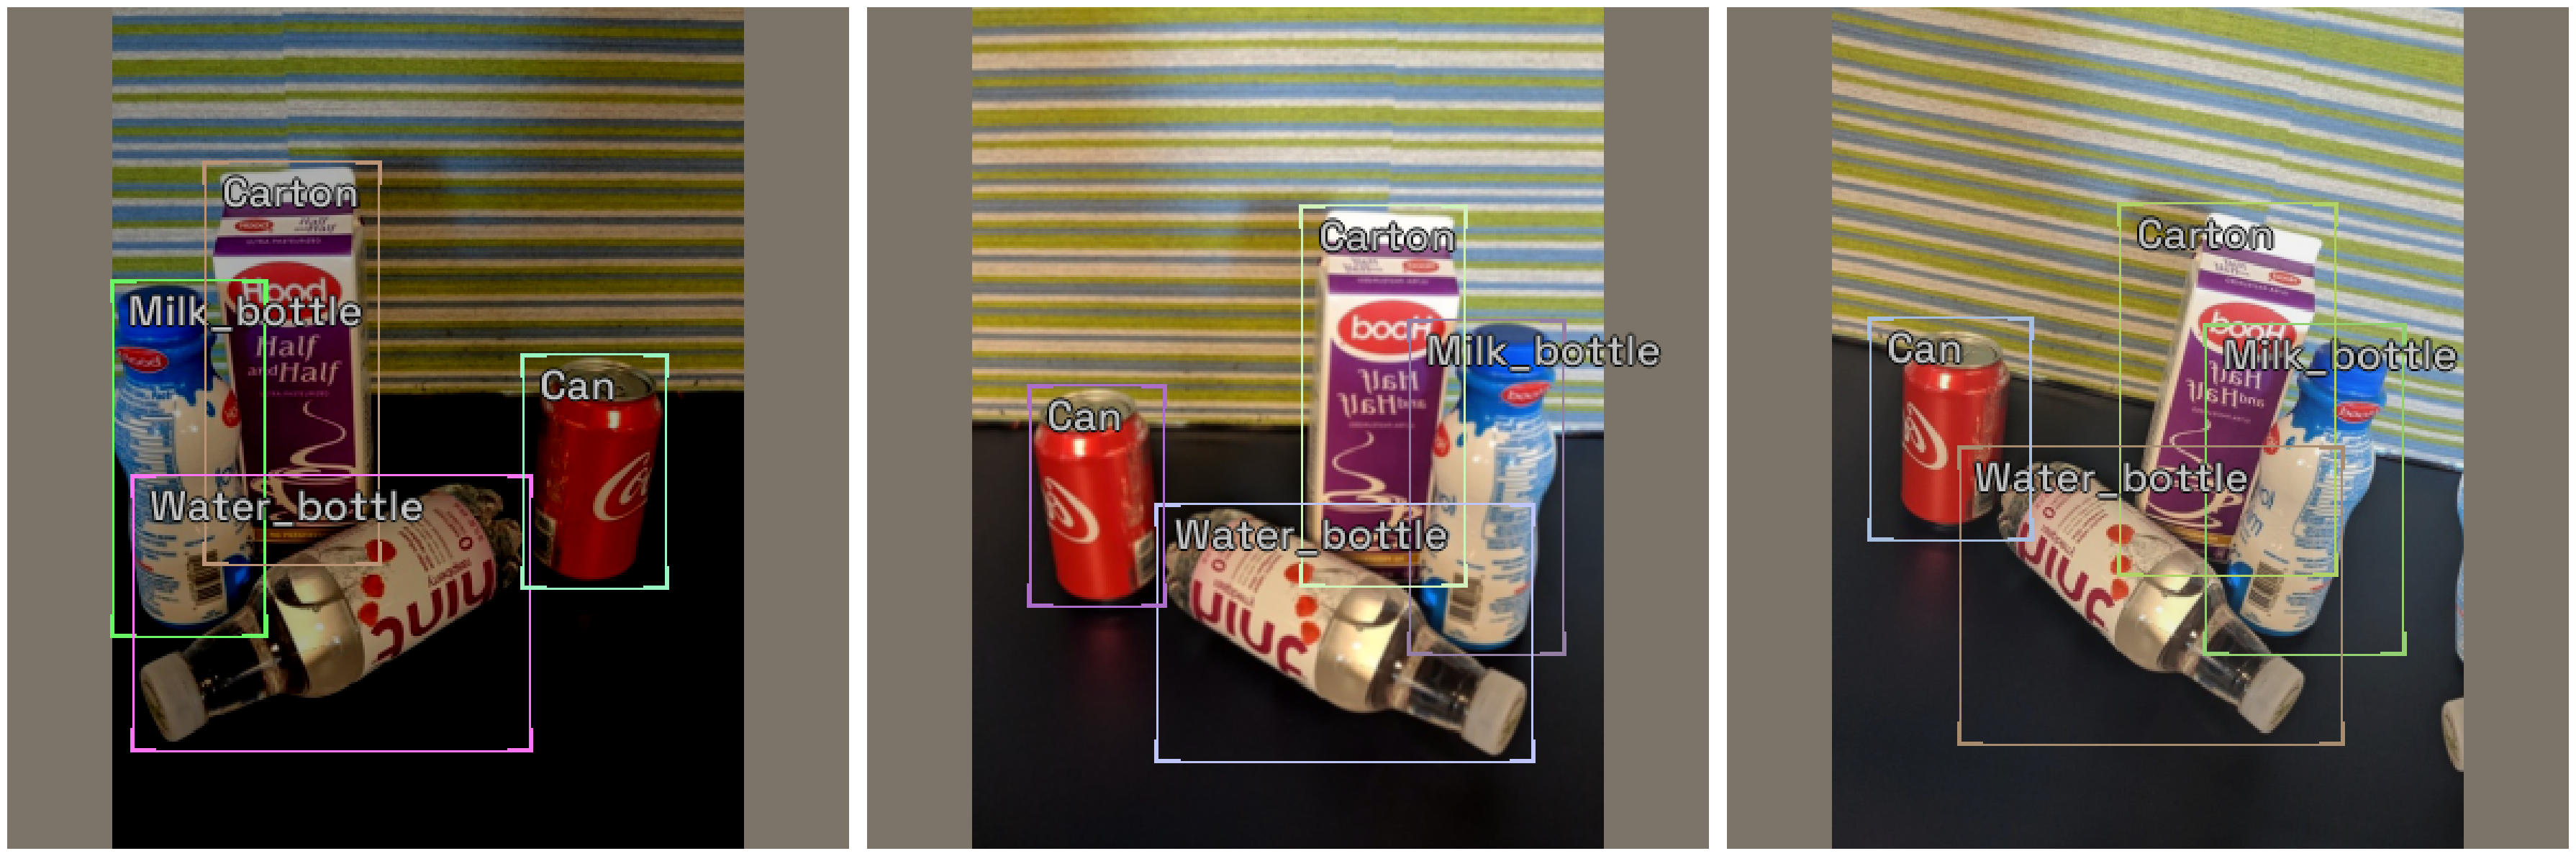

In [10]:
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

In [11]:
extra_args = {}
model_type = models.ultralytics.yolov5
backbone = model_type.backbones.small
# The yolov5 model requires an img_size parameter
extra_args['img_size'] = image_size

In [12]:
backbone.__dict__


{'model_name': 'yolov5s'}

In [13]:
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 


01/24/2023 18:51:38 - INFO - yolov5.models.yolo -   Overriding model.yaml nc=80 with nc=4
01/24/2023 18:51:38 - INFO - yolov5.models.yolo -   
                 from  n    params  module                                  arguments                     
01/24/2023 18:51:38 - INFO - yolov5.models.yolo -     0                -1  1      3520  yolov5.models.common.Conv               [3, 32, 6, 2, 2]              
01/24/2023 18:51:38 - INFO - yolov5.models.yolo -     1                -1  1     18560  yolov5.models.common.Conv               [32, 64, 3, 2]                
01/24/2023 18:51:38 - INFO - yolov5.models.yolo -     2                -1  1     18816  yolov5.models.common.C3                 [64, 64, 1]                   
01/24/2023 18:51:38 - INFO - yolov5.models.yolo -     3                -1  1     73984  yolov5.models.common.Conv               [64, 128, 3, 2]               
01/24/2023 18:51:38 - INFO - yolov5.models.yolo -     4                -1  2    115712  yolov5.models.common.C3   

In [14]:
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=0, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=0, shuffle=False)

In [15]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]


In [16]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(valley=0.001737800776027143)

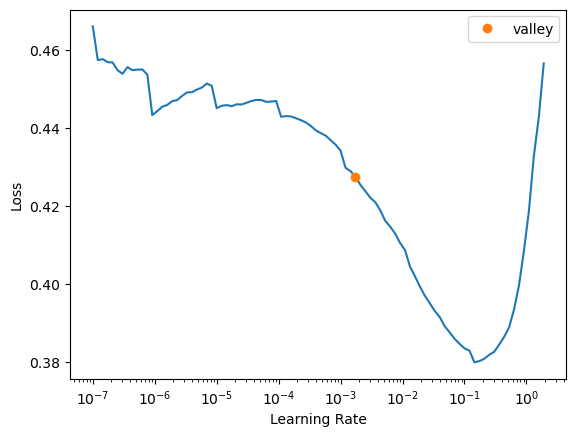

In [17]:
learn.lr_find()


In [18]:
learn.fine_tune(20, 0.00158, freeze_epochs=1)

epoch,train_loss,valid_loss,COCOMetric,time
0,0.419397,0.384931,0.030305,00:40


/Users/leilingtao/anaconda/envs/icevision/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch,train_loss,valid_loss,COCOMetric,time
0,0.351227,0.353302,0.061555,01:09
1,0.343407,0.310067,0.127777,01:06
2,0.317457,0.264222,0.251250,01:02
3,0.292219,0.229732,0.393602,00:56
4,0.267274,0.214640,0.353474,01:06
5,0.249591,0.183118,0.475091,01:10
6,0.232196,0.169186,0.550759,01:02
7,0.213413,0.164124,0.572174,01:00
8,0.197407,0.167269,0.499290,00:56
9,0.184694,0.151788,0.509925,01:02


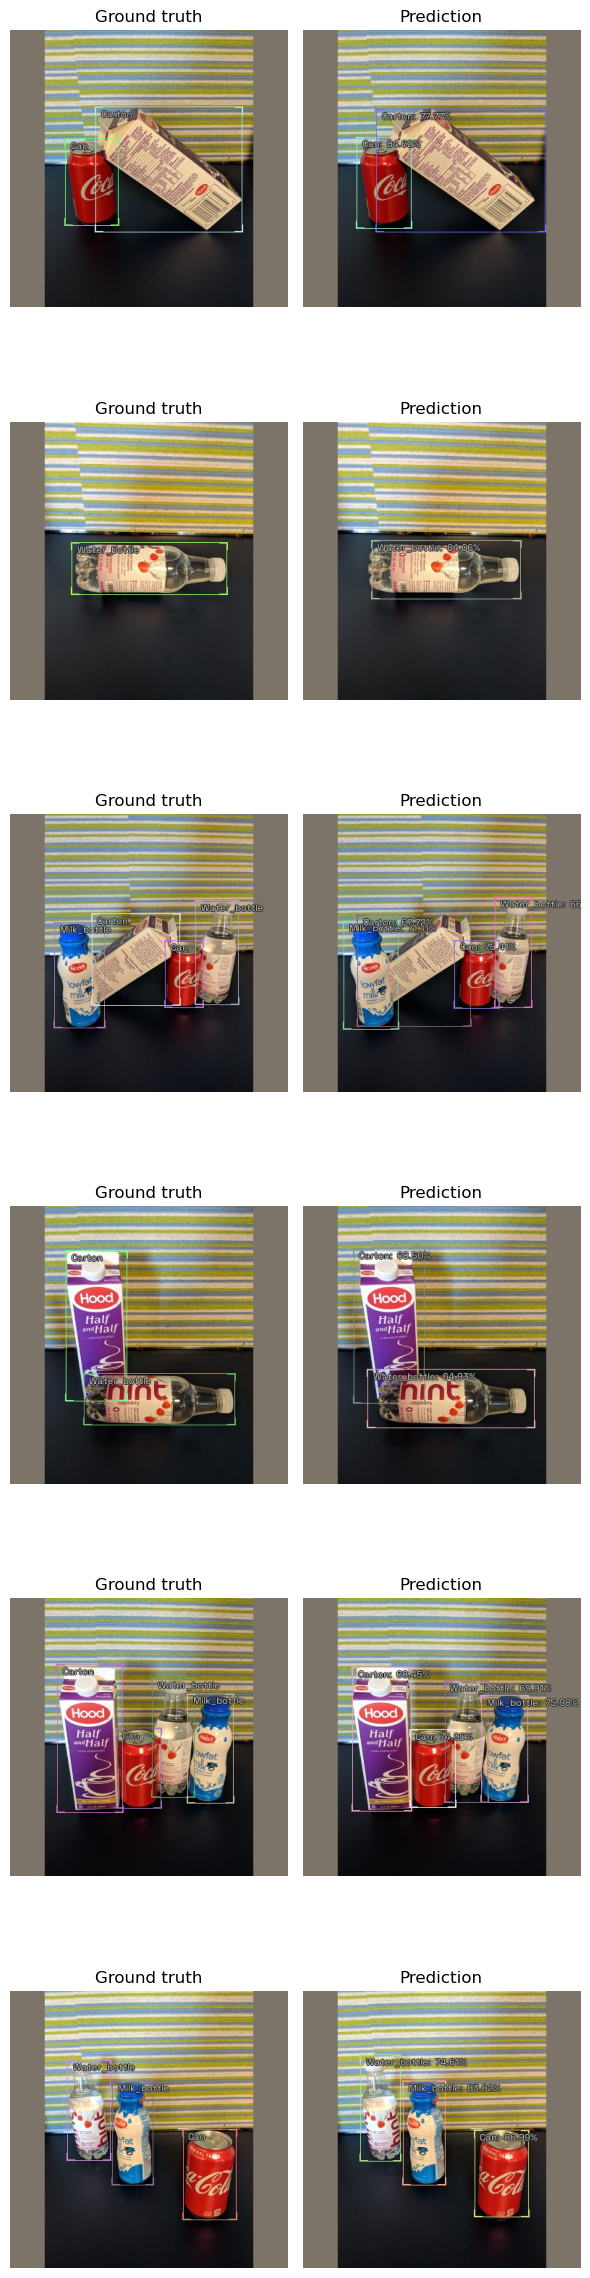

In [19]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

In [23]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/7 [00:00<?, ?it/s]

In [28]:
preds[0].pred

BaseRecord

common: 
	- Image size ImgSize(width=384, height=384)
	- Record ID: 96
	- Img: 384x384x3 <np.ndarray> Image
detection: 
	- Scores: [    0.84523]
	- Class Map: <ClassMap: {'background': 0, 'carton': 1, 'milk_bottle': 2, 'can': 3, 'water_bottle': 4}>
	- Labels: [1]
	- BBoxes: [<BBox (xmin:102.16675567626953, ymin:144.9207763671875, xmax:298.64898681640625, ymax:282.6296691894531)>]

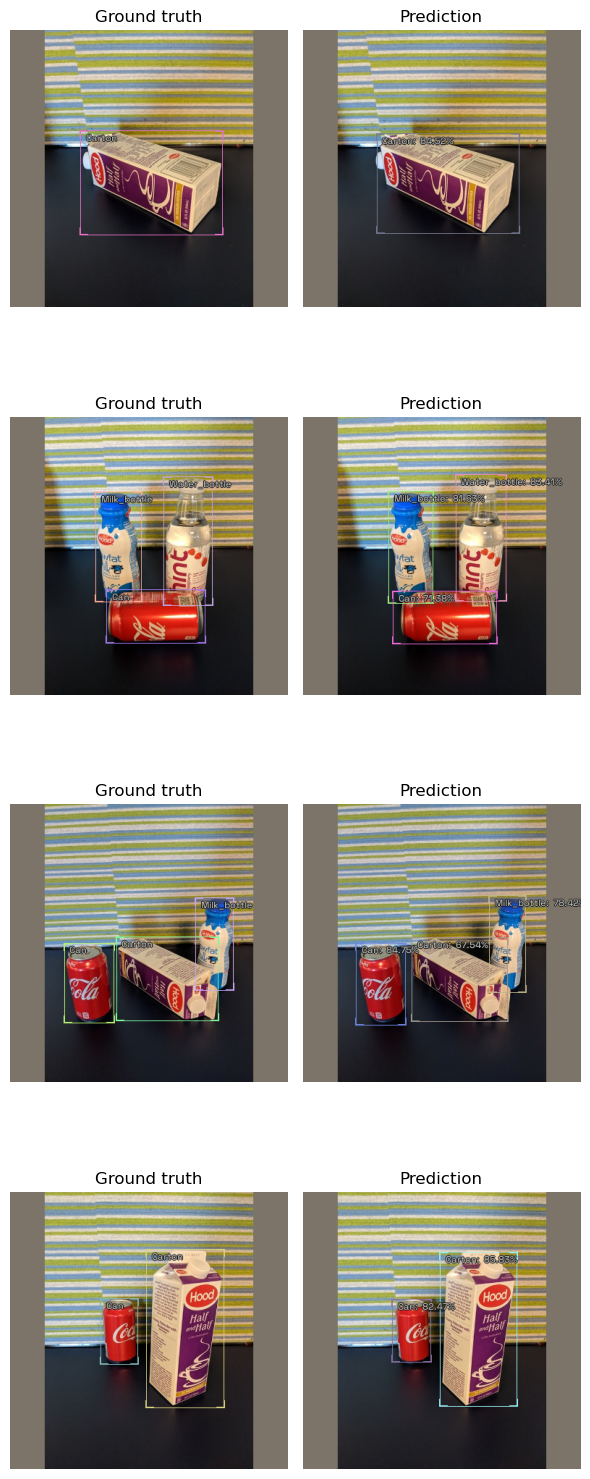

In [25]:
show_preds(preds=preds[:4])
